# clean_hh_2005

This notebook clean household level df 

## Inputs
1. ii_in.dta : household non labor income
2. ii_inr.dta : household rural income
3. ii_portad.dta : household location

Outputs
1. folio : household id
2. hh_no_savings : hh has no savings
2. hh_has_savings : hh has savings
2. hh_no_debts : hh has no debts
2. hh_has_debts : hh has debts
3. hh_has_liquid : hh has savings or debts

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os 

import sys; sys.path.append('/home/mitch/util/python')
sys.path.append('/home/mitch/school/mfl/')

from src import json_utils

In [173]:
raw = '/home/mitch/Dropbox/data/mexico_fls/raw/2005/'
interim = '/home/mitch/Dropbox/data/mexico_fls/interim2/2005/'

figs = '/home/mitch/github/mfl/fig/'
dicts= '/home/mitch/github/mfl/dicts/'

In [174]:
rename = json_utils.load_json(dicts + 'rename_hh_2005.json')
rename

{'folio': 'hhid',
 'fac_lib2': 'weight_hh',
 'ent': 'state',
 'ah03a': 'own_house',
 'ah03b': 'own_otherhouse',
 'ah03c': 'own_bicycles',
 'ah03d': 'own_vehicle',
 'ah03e': 'own_electronics',
 'ah03f': 'own_washmachinestove',
 'ah03g': 'own_domesticappliance',
 'ah03h': 'own_financialassets',
 'ah03i': 'own_machinary',
 'ah03j': 'own_bullcow',
 'ah03k': 'own_horsesmules',
 'ah03l': 'own_pigsgoats',
 'ah03m': 'own_poultry',
 'ah03n': 'own_otherassets',
 'ah04a_1': 'knowvalue_house',
 'ah04b_1': 'knowvalue_otherhouse',
 'ah04c_1': 'knowvalue_bicycles',
 'ah04d_1': 'knowvalue_vehicle',
 'ah04e_1': 'knowvalue_electronics',
 'ah04f_1': 'knowvalue_washmachinestove',
 'ah04g_1': 'knowvalue_domesticappliance',
 'ah04h_1': 'knowvalue_financialassets',
 'ah04i_1': 'knowvalue_machinary',
 'ah04j_1': 'knowvalue_bullcow',
 'ah04k_1': 'knowvalue_horsesmules',
 'ah04l_1': 'knowvalue_pigsgoats',
 'ah04m_1': 'knowvalue_poultry',
 'ah04n_1': 'knowvalue_otherassets',
 'ah04a_2': 'value_house',
 'ah04b_2'

In [175]:
os.chdir(raw + 'book II/data/' )

crh = pd.read_stata('ii_crh.dta')
ii_in = pd.read_stata('ii_in.dta')
ii_inr = pd.read_stata('ii_inr.dta')
ii_portad = pd.read_stata('ii_portad.dta')
ii_ah = pd.read_stata('ii_ah.dta').drop(columns=['ls'])
weights = pd.read_stata('hh05w_b2.dta')

os.chdir(raw + 'book I/data/' )
i_cs = pd.read_stata('i_cs.dta')
i_cs1 = pd.read_stata('i_cs1.dta')

os.chdir(raw + 'book C/data/' )
c_cv = pd.read_stata('c_cv.dta')


In [176]:
weights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8289 entries, 0 to 8288
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   folio     8289 non-null   object
 1   fac_lib2  8289 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 161.9+ KB


In [177]:
df = (crh.merge(weights, on=['folio'], how='left')
            .merge(ii_in, on=['folio'], how='left')
            .merge(ii_inr, on=['folio'], how='left')
            .merge(ii_portad, on=['folio'], how='left')
            .merge(i_cs, on=['folio'], how='left')
            .merge(i_cs1, on=['folio'], how='left')
            .merge(ii_ah, on=['folio'], how='left')
            .merge(c_cv, on=['folio'], how='left')
            )

In [178]:
df = df.rename(columns = rename)
df = df[rename.values()]

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8134 entries, 0 to 8133
Data columns (total 57 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   hhid                               8134 non-null   object 
 1   weight_hh                          8022 non-null   float64
 2   state                              8134 non-null   float32
 3   own_house                          8133 non-null   float32
 4   own_otherhouse                     8133 non-null   float32
 5   own_bicycles                       8133 non-null   float32
 6   own_vehicle                        8133 non-null   float32
 7   own_electronics                    8132 non-null   float32
 8   own_washmachinestove               8132 non-null   float32
 9   own_domesticappliance              8131 non-null   float32
 10  own_financialassets                8132 non-null   float32
 11  own_machinary                      8132 non-null   float

In [180]:
df.isna().sum()

hhid                                    0
weight_hh                             112
state                                   0
own_house                               1
own_otherhouse                          1
own_bicycles                            1
own_vehicle                             1
own_electronics                         2
own_washmachinestove                    2
own_domesticappliance                   3
own_financialassets                     2
own_machinary                           2
own_bullcow                             1
own_horsesmules                         1
own_pigsgoats                           1
own_poultry                             2
own_otherassets                        12
knowvalue_house                      1725
knowvalue_otherhouse                 6671
knowvalue_bicycles                   4970
knowvalue_vehicle                    5128
knowvalue_electronics                 756
knowvalue_washmachinestove           1076
knowvalue_domesticappliance       

In [181]:
df = df[~df.weight_hh.isna()]

In [182]:
df.isna().sum()

hhid                                    0
weight_hh                               0
state                                   0
own_house                               1
own_otherhouse                          1
own_bicycles                            1
own_vehicle                             1
own_electronics                         2
own_washmachinestove                    2
own_domesticappliance                   3
own_financialassets                     2
own_machinary                           2
own_bullcow                             1
own_horsesmules                         1
own_pigsgoats                           1
own_poultry                             2
own_otherassets                        12
knowvalue_house                      1664
knowvalue_otherhouse                 6574
knowvalue_bicycles                   4892
knowvalue_vehicle                    5042
knowvalue_electronics                 741
knowvalue_washmachinestove           1053
knowvalue_domesticappliance       

In [183]:
df.own_house.value_counts(dropna=False)

1.0    6358
3.0    1663
NaN       1
Name: own_house, dtype: int64

# State

In [184]:
relabel_state = json_utils.load_json(dicts + 'states.json')
relabel_state

{'3': 'Baja California Sur',
 '5': 'Coahuila',
 '6': 'Colima',
 '7': 'Chiapas',
 '9': 'Federal District',
 '10': 'Durango',
 '11': 'Guanajuato',
 '14': 'Jalisco',
 '15': 'State of Mexico',
 '16': 'Michoacan',
 '17': 'Morelos',
 '19': 'Nuevo Leon',
 '20': 'Oaxaca',
 '21': 'Puebla',
 '22': 'Queretaro',
 '23': 'Quintana Roo',
 '25': 'Sinaloa',
 '26': 'Sonora',
 '28': 'Tamaulipas',
 '30': 'Veravruz',
 '31': 'Yucatan'}

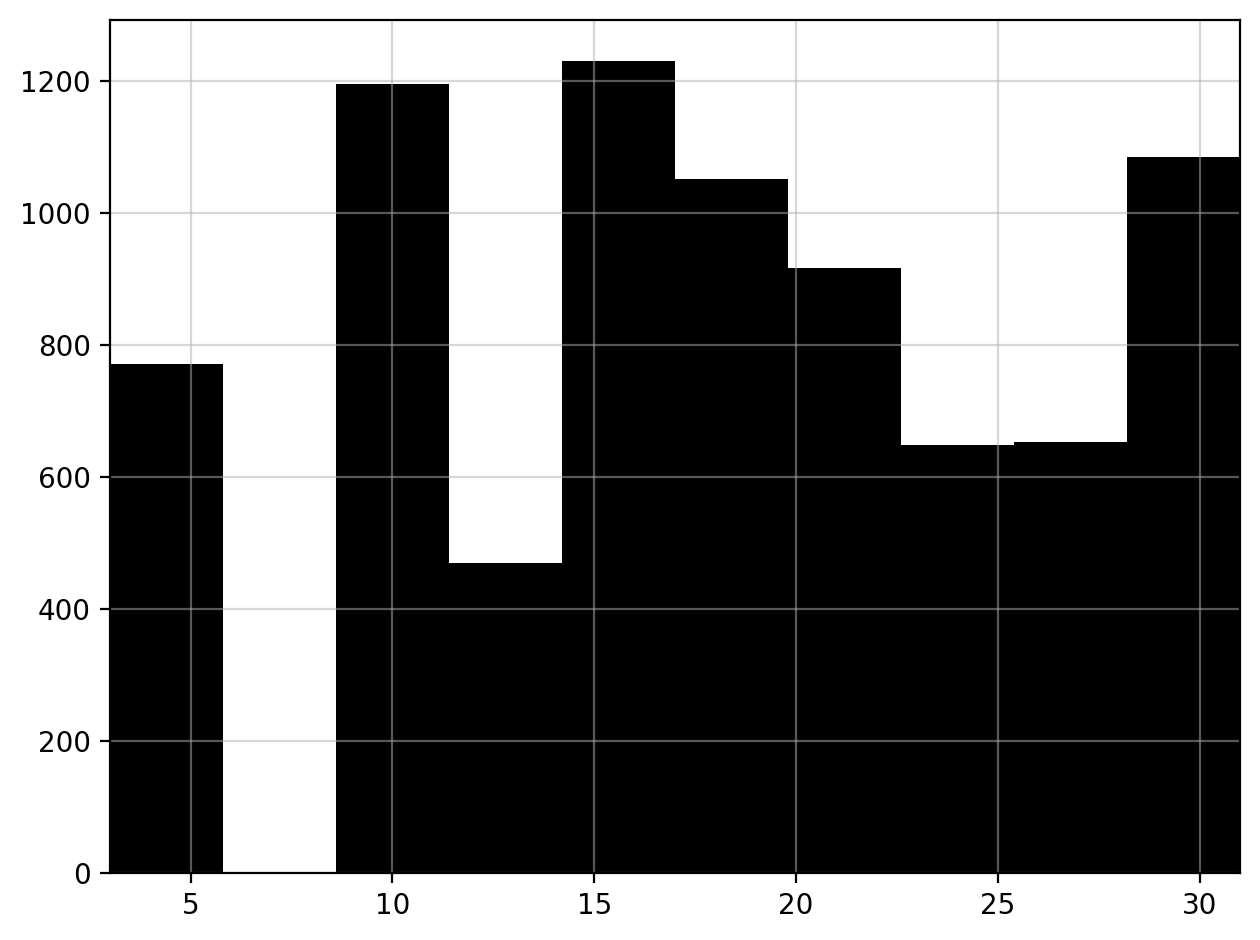

In [185]:
plt.clf()
df.state.hist()
plt.show()

In [186]:
df.state = df.state.astype(int).astype(str).replace(relabel_state)
df.state

0           Oaxaca
1           Oaxaca
2           Oaxaca
3           Oaxaca
4           Oaxaca
           ...    
8129    Nuevo Leon
8130    Nuevo Leon
8131    Nuevo Leon
8132    Nuevo Leon
8133    Nuevo Leon
Name: state, Length: 8022, dtype: object

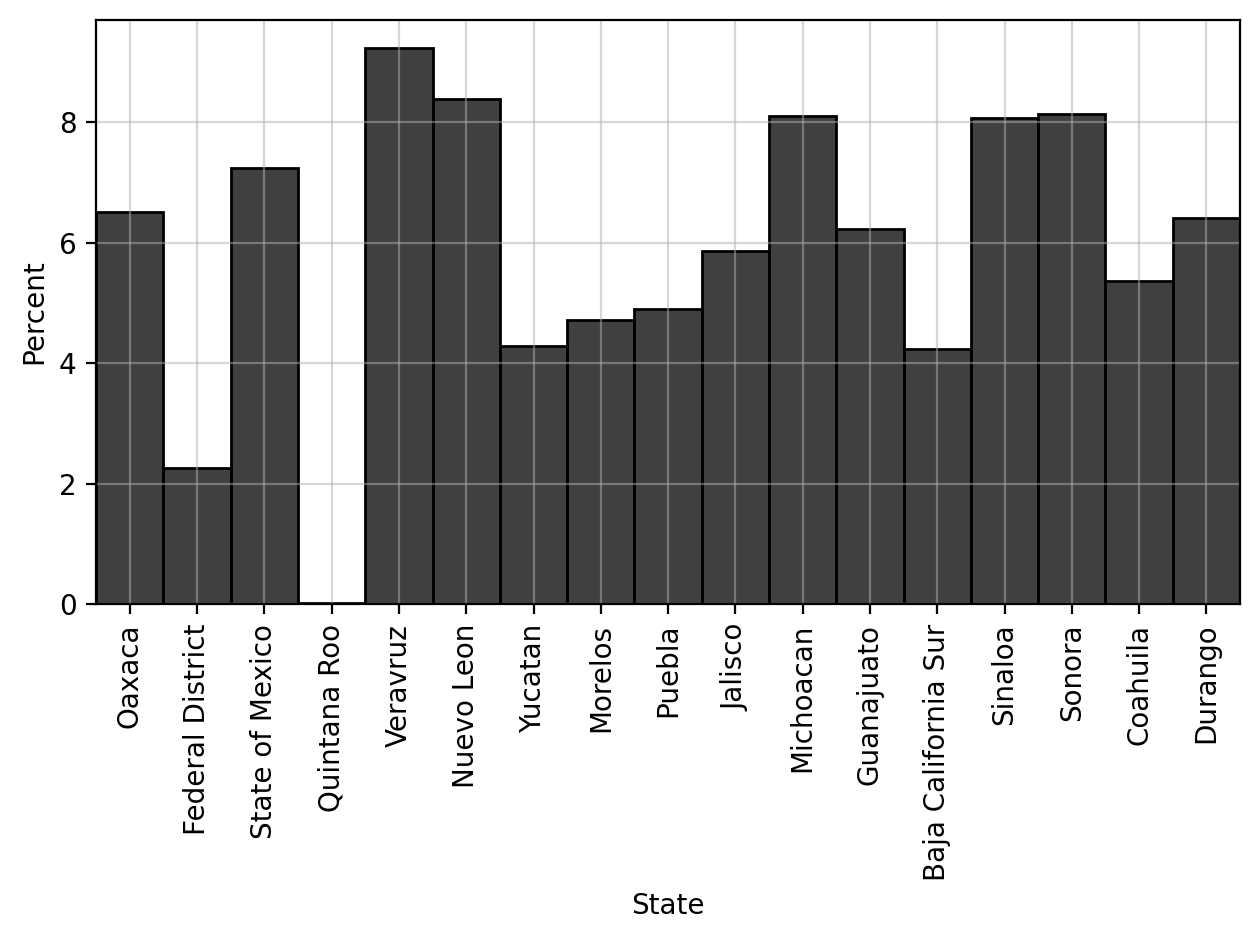

In [187]:
plt.clf()
sns.histplot(df, x='state', stat='percent')
plt.xticks(rotation=90)
plt.xlabel('State')
plt.show()

# Illiquid Assets

In [188]:
illiquid_assets = [
    'house', 
    'otherhouse',
    'bicycles',
    'vehicle',
    'electronics',
    'washmachinestove',
    'domesticappliance',
    'financialassets',
    'machinary',
    'bullcow',
    'horsesmules',
    'pigsgoats',
    'poultry',
    'otherassets'
]

In [189]:
df.own_house.value_counts()

1.0    6358
3.0    1663
Name: own_house, dtype: int64

In [190]:
for asset in illiquid_assets:
    df['own_'+asset] = df['own_'+asset].replace({1.0:1, 3.0:0}).fillna(0).astype(bool)
    df['knowvalue_'+asset] = df['knowvalue_'+asset].replace({1.0:1, 8.0:0})

In [191]:
for asset in illiquid_assets:
    own = df['own_' + asset] == 1
    dont_own = df['own_' + asset] == 0

    know_value = df['knowvalue_'+asset] == 1
    dk_value = df['knowvalue_'+asset] == 0

    df_own_know = df[own & know_value]

    df.loc[own & dk_value, 'value_' + asset] = (
        np.sum(df_own_know['value_' + asset] * df_own_know['weight_hh'])
        / np.sum(df_own_know['weight_hh'])
        )
    df.loc[dont_own, 'value_' + asset] = 0.0

In [192]:
df.hh_has_savings_person_not_hhm.value_counts(dropna=False)

NaN    8017
7.0       5
Name: hh_has_savings_person_not_hhm, dtype: int64

In [193]:
has_savings_types = [
    'hh_no_savings',
    'hh_has_savings_bank',
    'hh_has_savings_cooperative',
    'hh_has_savings_credit_institution',
    'hh_has_savings_batch',
    'hh_has_savings_person_not_hhm',
    'hh_has_savings_afores',
    'hh_has_savings_solidarity',
    'hh_has_savings_at_house',
    'hh_has_savings_other'
]

has_value = {
    'hh_no_savings'                       : 1.0,
    'hh_has_savings_bank'                 : 2.0,
    'hh_has_savings_cooperative'          : 3.0,
    'hh_has_savings_credit_institution'   : 4.0,
    'hh_has_savings_batch'                : 5.0,
    'hh_has_savings_person_not_hhm'       : 7.0,
    'hh_has_savings_afores'               : 8.0,
    'hh_has_savings_solidarity'           : 9.0,
    'hh_has_savings_at_house'             : 10.0,
    'hh_has_savings_other'                : 11.0
}

for savings_type in has_savings_types:
   df[savings_type] = df[savings_type].replace({
    has_value[savings_type]:1,
    np.nan:0
   }).astype(bool)

In [194]:
df.hh_has_savings_bank.astype(bool).value_counts()

False    7405
True      617
Name: hh_has_savings_bank, dtype: int64

In [195]:
df[has_savings_types].isna().sum()

hh_no_savings                        0
hh_has_savings_bank                  0
hh_has_savings_cooperative           0
hh_has_savings_credit_institution    0
hh_has_savings_batch                 0
hh_has_savings_person_not_hhm        0
hh_has_savings_afores                0
hh_has_savings_solidarity            0
hh_has_savings_at_house              0
hh_has_savings_other                 0
dtype: int64

In [196]:
has_savings_columns = [x for x in df.columns if 'hh_has_savings' in x]
df[has_savings_columns] = df[has_savings_columns].fillna(0)
has_savings_columns

['hh_has_savings_bank',
 'hh_has_savings_cooperative',
 'hh_has_savings_credit_institution',
 'hh_has_savings_batch',
 'hh_has_savings_person_not_hhm',
 'hh_has_savings_afores',
 'hh_has_savings_solidarity',
 'hh_has_savings_at_house',
 'hh_has_savings_other']

In [197]:
df['hh_has_savings'] = df[has_savings_columns].sum(axis=1) > 0
df['hh_has_savings'].value_counts()

False    6971
True     1051
Name: hh_has_savings, dtype: int64

In [198]:
df['hh_has_debts_12mth'].value_counts(dropna=False)

2.0    5900
1.0    2026
8.0      93
NaN       3
Name: hh_has_debts_12mth, dtype: int64

In [199]:
df['hh_has_debts_12mth'] = df['hh_has_debts_12mth'].replace(
    {1.0:1.0, 2.0:0.0, 8.0:0.0}
)
has_debt    = df['hh_has_debts_12mth'] == 1.0
no_debt     = df['hh_has_debts_12mth'] == 0.0

df.loc[no_debt, 'hh_debts_12mth'] = 0.0

In [200]:
knowvalue = [x for x in df.columns if 'knowvalue' in x]
df = df.drop(columns = knowvalue)

In [201]:
own = [x for x in df.columns if 'own' in x]
own

['own_house',
 'own_otherhouse',
 'own_bicycles',
 'own_vehicle',
 'own_electronics',
 'own_washmachinestove',
 'own_domesticappliance',
 'own_financialassets',
 'own_machinary',
 'own_bullcow',
 'own_horsesmules',
 'own_pigsgoats',
 'own_poultry',
 'own_otherassets']

In [202]:
df[own]

,own_house,own_otherhouse,own_bicycles,own_vehicle,own_electronics,own_washmachinestove,own_domesticappliance,own_financialassets,own_machinary,own_bullcow,own_horsesmules,own_pigsgoats,own_poultry,own_otherassets
0,True,False,True,False,False,True,False,True,False,False,False,False,True,False
1,False,False,False,True,True,True,True,False,False,False,False,False,False,False
2,True,False,True,False,True,True,True,False,False,False,False,False,False,False
3,True,False,True,False,True,True,True,False,False,False,False,True,False,False
4,True,False,True,True,True,True,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8129,True,False,True,True,True,True,True,True,False,False,False,True,False,False
8130,True,False,True,True,True,True,True,False,False,False,False,False,True,False
8131,True,True,True,True,True,True,False,False,False,False,False,False,False,False
8132,True,False,True,True,True,True,True,False,False,False,False,False,False,False


In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8022 entries, 0 to 8133
Data columns (total 44 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   hhid                               8022 non-null   object 
 1   weight_hh                          8022 non-null   float64
 2   state                              8022 non-null   object 
 3   own_house                          8022 non-null   bool   
 4   own_otherhouse                     8022 non-null   bool   
 5   own_bicycles                       8022 non-null   bool   
 6   own_vehicle                        8022 non-null   bool   
 7   own_electronics                    8022 non-null   bool   
 8   own_washmachinestove               8022 non-null   bool   
 9   own_domesticappliance              8022 non-null   bool   
 10  own_financialassets                8022 non-null   bool   
 11  own_machinary                      8022 non-null   bool 

In [204]:
os.chdir(interim)
df.to_csv('hh_2005.csv', index=False)